## Load data and get heartbeats

In [12]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import os
from scipy.signal import find_peaks


In [ ]:
def plot_heartbeats(heartbeats, faster_heartbeat):
    plt.figure(figsize=(12, 6))
    
    # Plot the first heartbeat
    plt.subplot(2, 1, 1)
    plt.plot(heartbeats[0])
    plt.title('Heartbeat 1')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Plot the second heartbeat
    plt.subplot(2, 1, 2)
    plt.plot(heartbeats[1])
    plt.title('Heartbeat 2')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    # Plot the faster heartbeat
    plt.figure(figsize=(6, 4))
    plt.plot(faster_heartbeat)
    plt.title('Faster Heartbeat')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def extract_heartbeats(filename, sampling_rate=360):
    # Open file
    mat_file = loadmat(filename)
    data = mat_file['val'].reshape(4, -1)    
    
    # ICA to extract signals from mixture
    decomposed_data = FastICA(n_components=4).fit_transform(data.T).T
    
    # Threshold to distinguish heartbeat and noise
    threshold = 1
    spike_counts = np.sum(decomposed_data > threshold, axis=1)
    
    # Heartbeats have fewer spikes than noise
    idx_heartbeats = np.argsort(spike_counts)[:2]
    
    heartbeats = decomposed_data[idx_heartbeats]

    # Ensure heartbeats are oriented correctly
    for i in range(len(heartbeats)):
        if np.max(np.abs(heartbeats[i])) == np.abs(np.min(heartbeats[i])):
            heartbeats[i] = -heartbeats[i]
    
    def calculate_rr_intervals(heartbeat):
        r_peaks = np.where(heartbeat > np.mean(heartbeat))[0]
        rr_intervals = np.diff(r_peaks) / sampling_rate
        return rr_intervals
    
    # Calculate RR intervals for each heartbeat
    rr_intervals_1 = calculate_rr_intervals(heartbeats[0])
    rr_intervals_2 = calculate_rr_intervals(heartbeats[1])
    
    # Calculate average RR interval for each heartbeat
    avg_rr_1 = np.mean(rr_intervals_1) if len(rr_intervals_1) > 0 else float('inf')
    avg_rr_2 = np.mean(rr_intervals_2) if len(rr_intervals_2) > 0 else float('inf')
    
    # Determine the faster heartbeat (shorter average RR interval)
    faster_heartbeat = heartbeats[0] if avg_rr_1 < avg_rr_2 else heartbeats[1]

    #plot_heartbeats(heartbeats, faster_heartbeat)
    
    return faster_heartbeat



directory = 'data/test-data'

all_test_heartbeats =[]

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if filename.endswith('.mat'):
            heartbeats = extract_heartbeats(file_path)
            all_test_heartbeats.append(heartbeats)
        
    
    

## Some plot functions

In [ ]:
def plot_heartbeats(heartbeats, faster_heartbeat):
    plt.figure(figsize=(12, 6))
    
    # Plot the first heartbeat
    plt.subplot(2, 1, 1)
    plt.plot(heartbeats[0])
    plt.title('Heartbeat 1')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Plot the second heartbeat
    plt.subplot(2, 1, 2)
    plt.plot(heartbeats[1])
    plt.title('Heartbeat 2')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    # Plot the faster heartbeat
    plt.figure(figsize=(6, 4))
    plt.plot(faster_heartbeat)
    plt.title('Faster Heartbeat')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

# Example usage


## Extract features and cluster

153


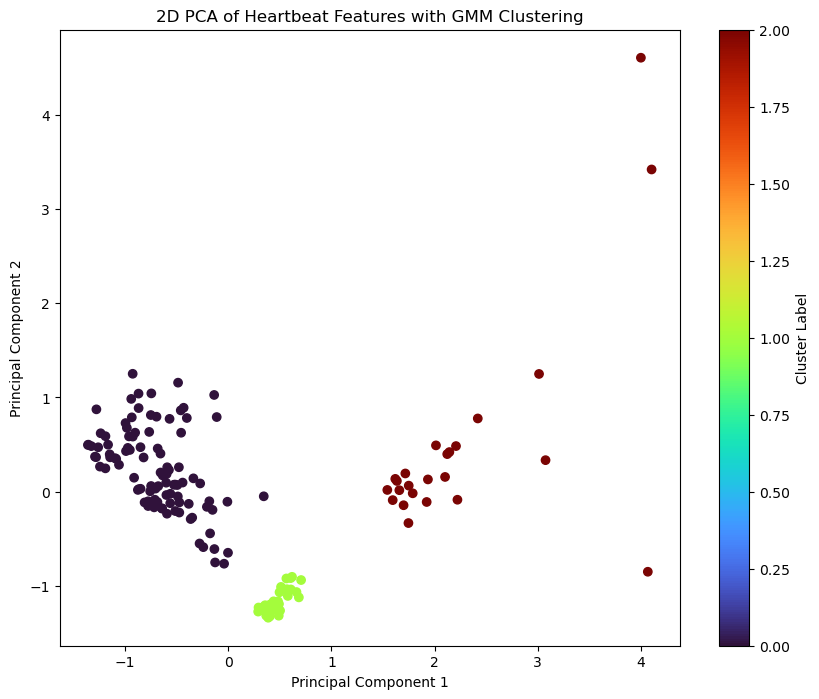

Principal Component 1: 66.45% variance explained
Principal Component 2: 33.55% variance explained
Total variance explained by selected components: 100.00%


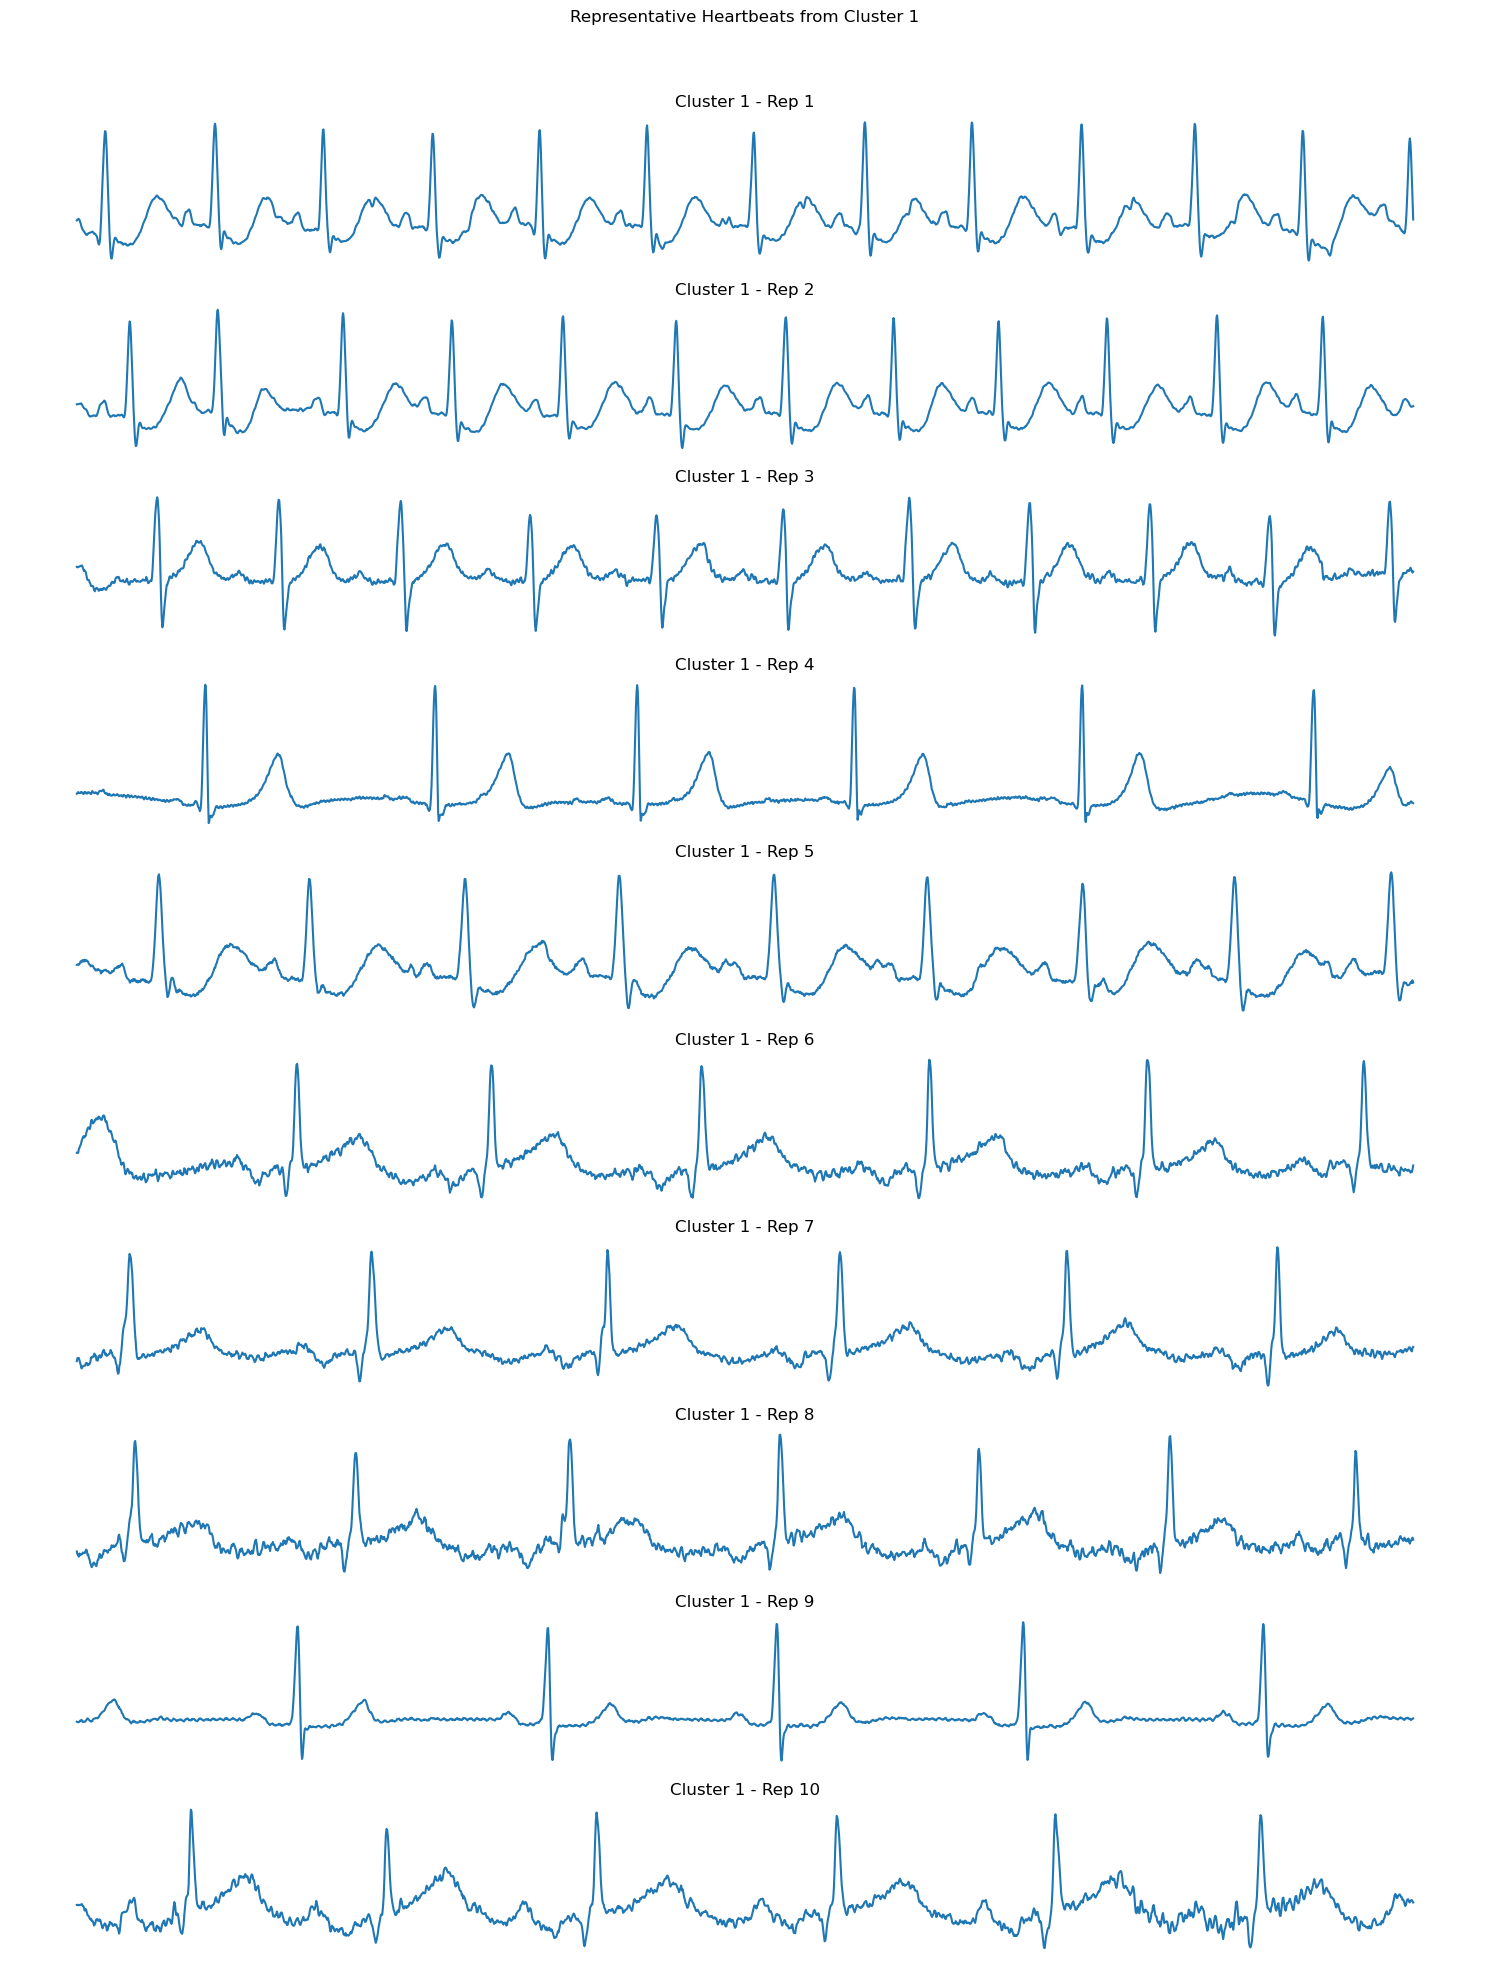

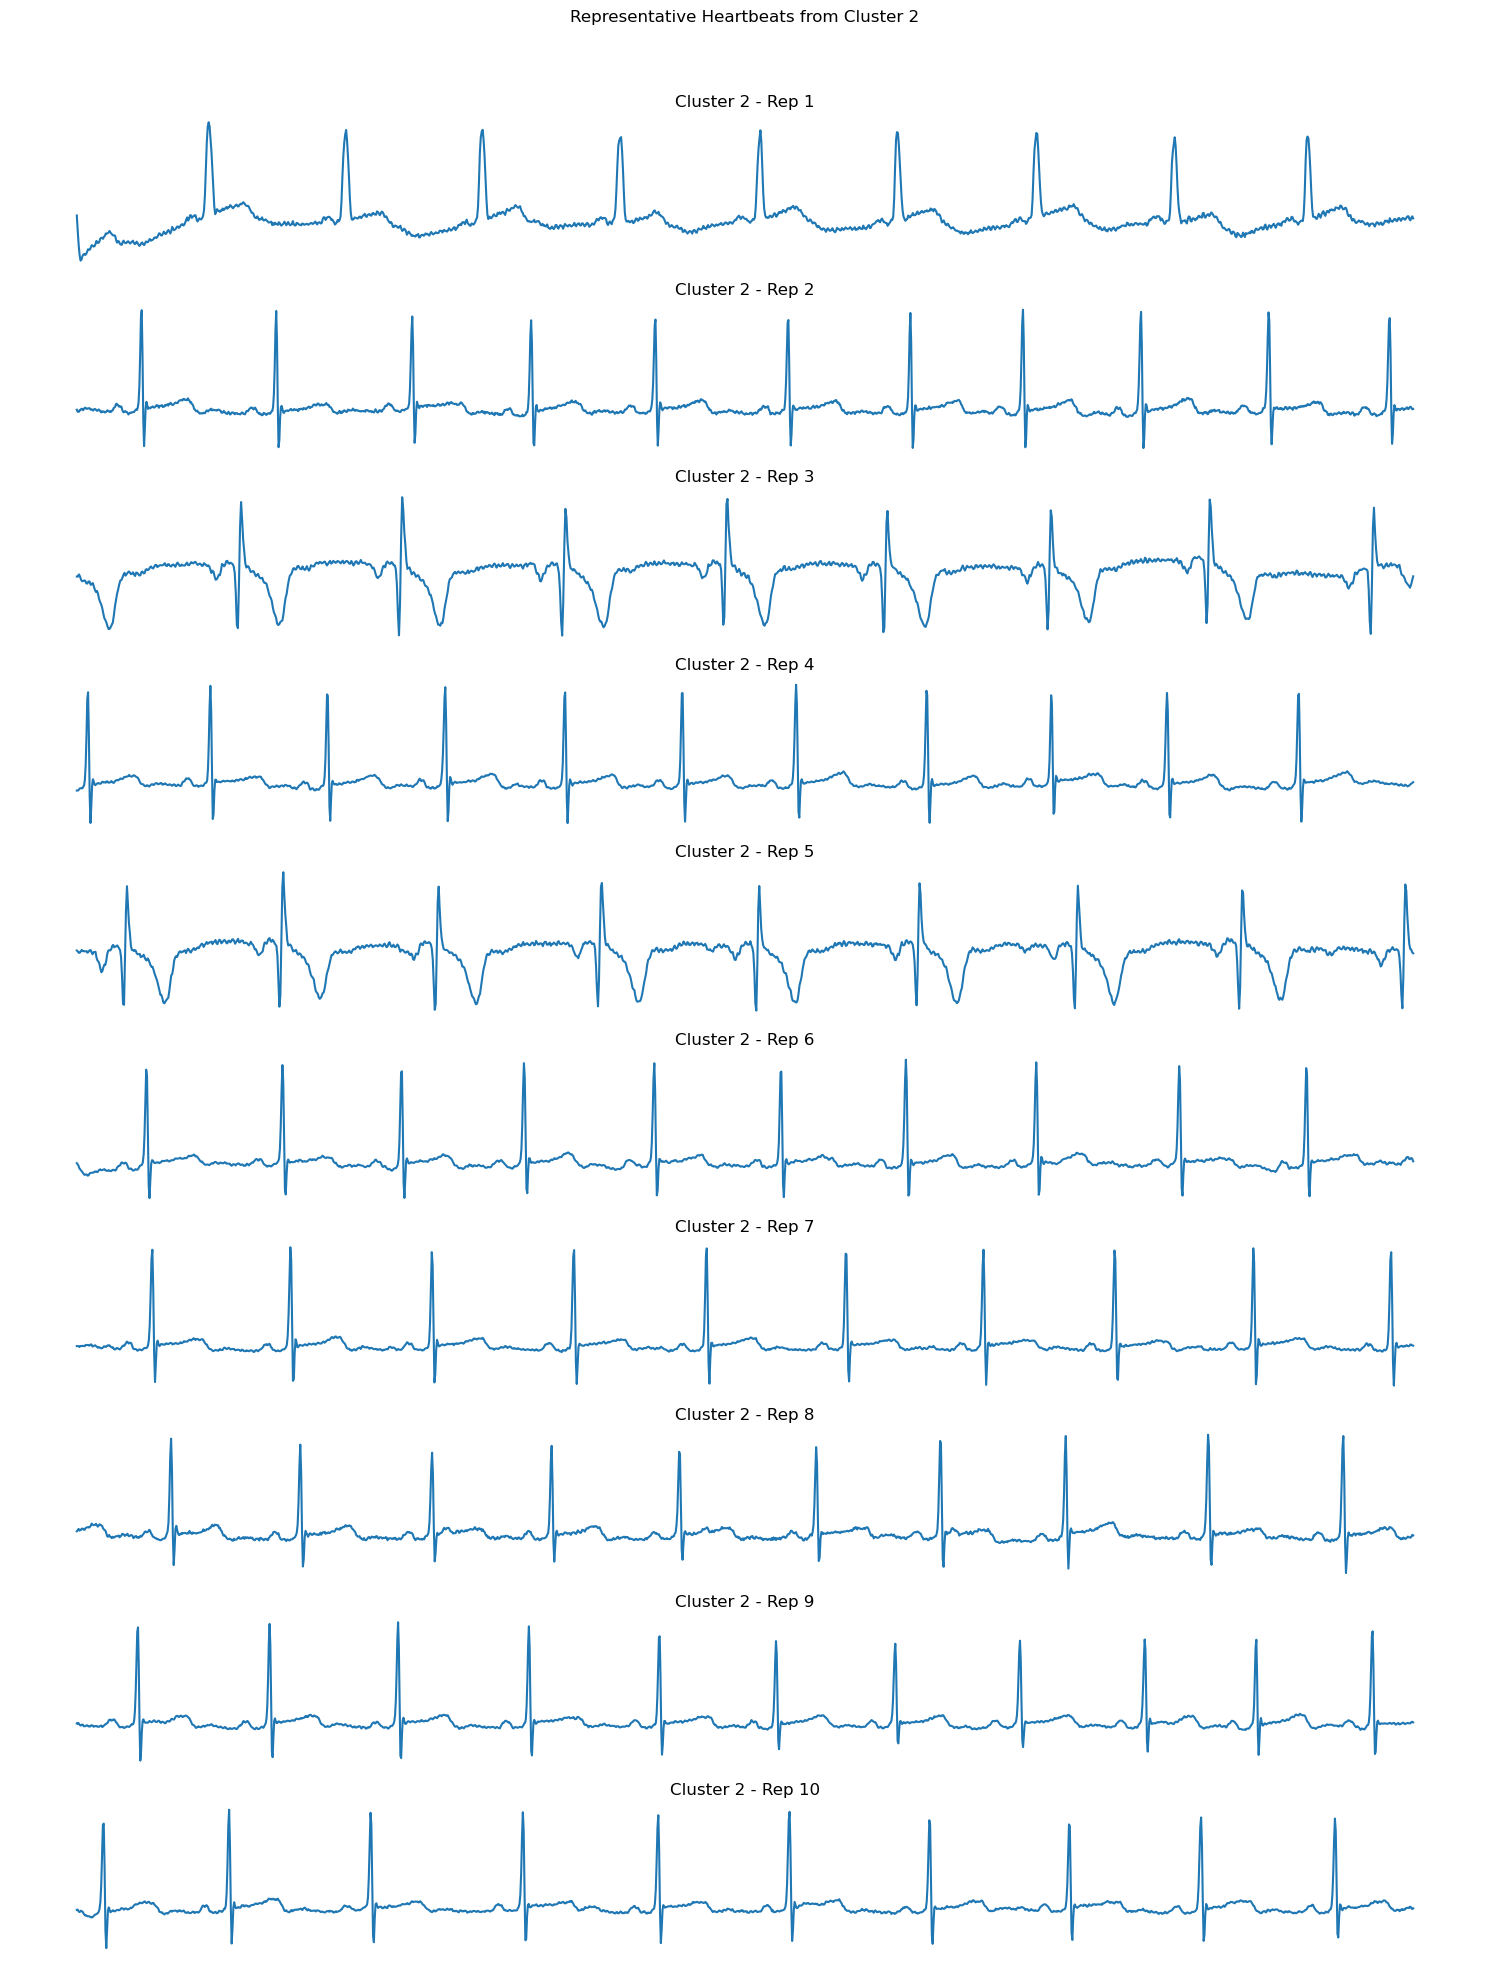

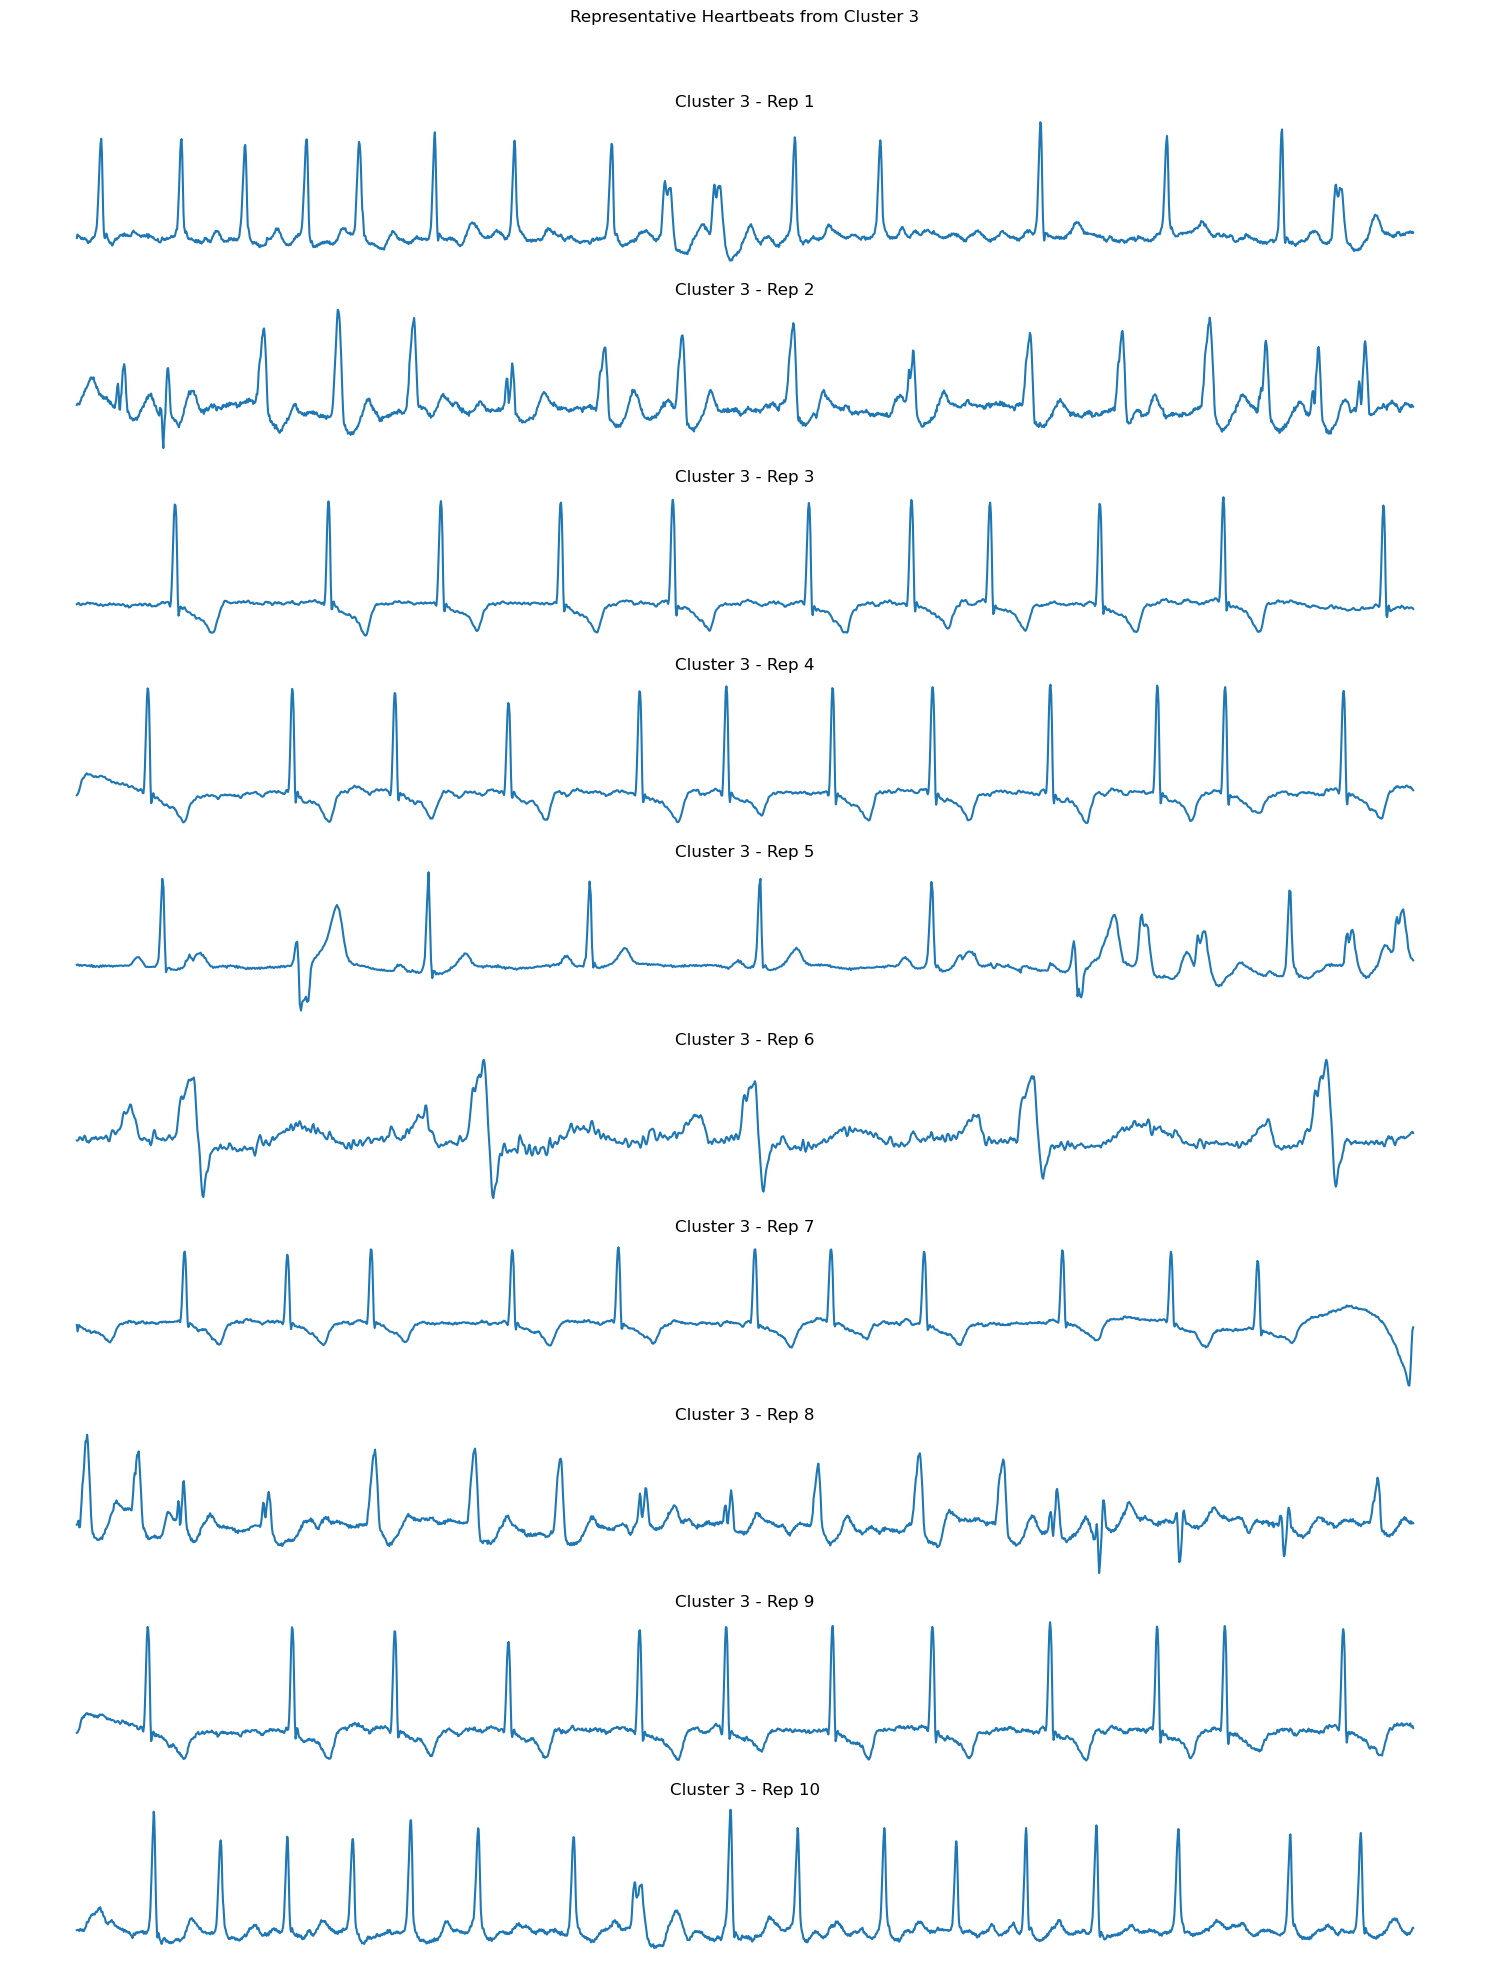

Principal Component 1 Loadings:
mean_rr: 0.7071
sdnn: 0.7071

Principal Component 2 Loadings:
mean_rr: -0.7071
sdnn: 0.7071



In [30]:
import numpy as np
import scipy.stats as stats
from scipy.signal import welch, hilbert
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import mahalanobis
def extract_features_from_heartbeat(heartbeats, sampling_rate=360):
    features = []
    
    for heartbeat in heartbeats:

        peaks, properties = find_peaks(heartbeat, height=0.4, distance=40, prominence=2.2, width=(None,30))
        bpm = len(peaks)/len(heartbeat)
        distance_between_spikes = np.std(np.diff(peaks))
        ptp_std = np.std(heartbeat[peaks])
        # take std of peak to peak
        

        #windows_arr = get_heartbeat_windows([heartbeat], [peaks[0]])
        #length_window = np.std([len(window) for window in windows_arr[0]])
         # Morphological features

        #a = np.trapz(heartbeat)

        
        features.append([
           bpm, distance_between_spikes#, ptp_std
        ])
    
    features = np.array(features)
    
    # Normalize the features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    return normalized_features

# Example usage
# Assuming `all_test_heartbeats` is defined elsewhere in your code

from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Define your cutoff frequency in Hz
sampling_rate = 360  # Define your sampling rate in Hz

filtered_heartbeats = [highpass_filter(heartbeat, cutoff_frequency, sampling_rate) for heartbeat in all_test_heartbeats]
print(len(filtered_heartbeats))

normalized_features = extract_features_from_heartbeat(filtered_heartbeats)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)

gmm = GaussianMixture(n_components=3)
labels = gmm.fit_predict(normalized_features)

######################################## TOP 10 POINTS FROM EACH CLUSTER #############################################
means = gmm.means_
covariances = gmm.covariances_

furthest_points = {i: [] for i in range(3)}

for cluster_idx in range(3):
    # Select data points belonging to the current cluster
    cluster_points = normalized_features[labels == cluster_idx]
    
    # Compute the inverse of the covariance matrix for Mahalanobis distance
    inv_cov = np.linalg.inv(covariances[cluster_idx])
    
    # Calculate Mahalanobis distance for each point
    distances = [
        mahalanobis(point, means[cluster_idx], inv_cov) for point in cluster_points
    ]
    
    # Sort points by distance in descending order
    sorted_indices = np.argsort(distances)[::-1]
    
    # Get the top 10 furthest points (or fewer if less than 10)
    top_10_indices = sorted_indices[:10]
    furthest_points[cluster_idx] = top_10_indices



responsibilities = gmm.predict_proba(normalized_features)

# Predict the cluster for each point
cluster_assignments = gmm.predict(normalized_features)


for cluster_idx in range(3):
    # Select data points belonging to the current cluster
    cluster_points = normalized_features[cluster_assignments == cluster_idx]
    
    # Select responsibilities for the current cluster
    cluster_responsibilities = responsibilities[cluster_assignments == cluster_idx, cluster_idx]
    
    # Sort points by responsibility (ascending, since lower is less likely)
    sorted_indices = np.argsort(cluster_responsibilities)
    
    # Get the top 10 least likely points (lowest responsibility)
    top_10_indices = sorted_indices[:10]
    #unlikeliest_points[cluster_idx] = top_10_indices

#############################################################################
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='turbo', marker='o')
ax.set_title('2D PCA of Heartbeat Features with GMM Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
fig.colorbar(scatter, label='Cluster Label')
plt.show()

for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%} variance explained")

print(f"Total variance explained by selected components: {total_variance:.2%}")

# Plot ten representative heartbeats from each cluster
num_representatives = 10
unique_labels = np.unique(labels)

# Dictionary to store global indices of unlikeliest points
unlikeliest_points = {i: [] for i in range(3)}

for cluster_idx in range(3):
    # Get global indices of points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_idx)[0]
    
    # Select normalized features for the current cluster
    cluster_points = normalized_features[cluster_indices]
    
    # Compute the log probability of each point under the Gaussian component
    log_probs = gmm.score_samples(cluster_points)
    
    # Sort points by log probability (ascending, since lower is less likely)
    sorted_indices = np.argsort(log_probs)
    
    # Get the top 10 least likely points (lowest log-probability)
    top_10_local_indices = np.unique(sorted_indices[:10])  # Ensure unique indices
    
    # If fewer than 10 unique points are found, pad with additional points
    while len(top_10_local_indices) < 10:
        top_10_local_indices = np.concatenate(
            top_10_local_indices, sorted_indices[len(top_10_local_indices)]
        )
    
    # Convert local indices back to global indices
    top_10_global_indices = cluster_indices[top_10_local_indices]
    
    # Store global indices
    unlikeliest_points[cluster_idx] = top_10_global_indices

# Number of representatives to visualize per cluster
num_representatives = 10

for cluster in range(3):  # Iterate over each cluster
    plt.figure(figsize=(15, 20))
    
    for i, idx in enumerate(unlikeliest_points[cluster]):
        plt.subplot(num_representatives, 1, i + 1)
        plt.plot(filtered_heartbeats[idx])  # Use global index for plotting
        plt.title(f'Cluster {cluster + 1} - Rep {i + 1}')
        plt.axis('off')
    
    plt.suptitle(f'Representative Heartbeats from Cluster {cluster + 1}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Number of representatives to visualize per cluster

# Get the loadings
loadings = pca.components_

# Print the loadings
feature_names = [
    "mean_rr", "sdnn", "rmssd", "pnn50"
]

for i, component in enumerate(loadings):
    print(f"Principal Component {i+1} Loadings:")
    for feature, loading in zip(feature_names, component):
        print(f"{feature}: {loading:.4f}")
    print()
